<h1>Advanced Data Science Capstone</h1>

<h2>Introduction</h2>

My project is based on "Spaceship Titanic", a Kaggle Competition. It is a project about choosing the appropriate learning method after comparing the accuracy of different models with each other. Six different models such as "Logistic Regression", "GBT Classifier", "Linear SVC", "Decision Tree Classifier", "Random Forest Classifier", "Multilayer Perceptron Classifier" were applied and the one with the highest accuracy was sought. Spark ML was used in the study.

The scenario is as follows:

<i>"Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

<i>The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

<i>While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

<i>To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

<i>Help save them and change history!

<i>In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system."</i>

# **Table of Contents**
* [Data Source](#1)
* [Importing Libraries](#2)
* [Reading the data](#3)
* [Exploratory Data Analysis](#4)
* [Feature Engineering](#5)
* [Spark ML Models](#6)

<a id='1'></a>
<h2>Data Source</h2>
The data set is a data set containing the information of transported persons and private individuals in the "Space Ship Titanic", taken from https://www.kaggle.com/code/gusthema/spaceship-titanic-with-tfdf/

<h3>File and Data Field Descriptions</h3>
<p><code>train.csv</code> - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.</p>
<p><code>PassengerId</code> - A unique Id for each passenger.</p>
<p><code>HomePlanet</code> - The planet the passenger departed from, typically their planet of permanent residence.</p>
<p><code>CryoSleep</code> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.</p>
<p><code>Cabin</code> - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.</p>
<p><code>Destination</code> - The planet the passenger will be debarking to.</p>
<p><code>Age</code> - The age of the passenger.</p>
<p><code>VIP</code> - Whether the passenger has paid for special VIP service during the voyage.</p>
<p><code>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</code> - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.</p>
<p><code>Name</code> - The first and last names of the passenger.</p>
<p><code>Transported</code> - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.</p>
<p><code>test.csv</code> - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.</p>


First, we install the necessary library for Pyspark 

In [219]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


<a id='2'></a>
# **Importing Libraries**

In [220]:
import warnings  # Base category for warnings triggered during the process of importing a module (ignored by default)
warnings.filterwarnings('ignore')  # here we prescribe the action in case of an error.

import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from collections import Counter
import re
from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F



#Creating spark session
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)


from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='3'></a>
# **Reading the data**

In [221]:
def concat_dataframes(train_data, test_data):
    '''Creates a concatenated data frame whose input is the training and test data set without an index in its output.'''
    # Returns a concatenated dataframes of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    '''A function whose input is concatenated using the training and test dataframes, 
    and whose output is unlabeled dataframes that are the training dataframe and test dataframe using this data frame.'''
    # Returns divided dataframes of training and test set
    return all_data.loc[:8692], all_data.loc[8693:].drop(['Transported'], axis=1)

df_train = pd.read_csv('sp_train.csv')
df_test = pd.read_csv('sp_test.csv')
df_all= concat_dataframes(df_train,df_test)


#We assign names to dataframes
df_train.name = 'Training Set'  # set parameter for dataset - dataframe name
df_test.name = 'Test Set'  # set parameter for dataset - dataframe name
df_all.name = 'All Set'  # set parameter for dataset - dataframe name 

dfs = [df_train, df_test]


In [222]:
df_train.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1416,1500_01,Earth,False,G/230/S,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,0.0,Hollie Cooperkins,False
2350,2532_01,Mars,False,F/489/S,TRAPPIST-1e,24.0,False,737.0,37.0,1682.0,0.0,0.0,Gorn Traie,False
8335,8901_01,Europa,True,B/341/S,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Alphah Cousel,True
2681,2871_02,Europa,True,B/88/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Sarthim Unregul,True
2453,2631_01,Mars,True,F/545/P,55 Cancri e,50.0,False,0.0,0.0,0.0,0.0,0.0,Sealfs Queke,True
2209,2365_01,Europa,True,D/71/P,TRAPPIST-1e,50.0,False,0.0,0.0,NaN,0.0,0.0,Spuri Clunic,True
1849,1976_03,Europa,True,B/82/S,55 Cancri e,26.0,True,0.0,0.0,0.0,0.0,0.0,Cellah Lansuffle,True
5165,5514_04,Earth,False,G/889/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,NaN,Jodip Monroellynn,True
8078,8637_02,Mars,False,F/1773/P,TRAPPIST-1e,25.0,False,987.0,0.0,6221.0,141.0,0.0,Varz Spien,True
4476,4758_01,Earth,False,F/966/P,TRAPPIST-1e,44.0,False,248.0,0.0,0.0,0.0,623.0,Luzel Woody,False


In [223]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# <a id='4'></a>
# **Exploratory Data Analysis**

<p>train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.</p>
<p>test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Our task is to predict the value of Transported for the passengers in this set.</p>


<p><code>PassengerId:</code> A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.</p>
<p><code>Transported</code> is the target variable we are trying to predict (0 or 1 / False or True):</p>
<p>True = 1 = Transported</p>
<p>False = 0 = Not Transported</p>
<p><code>CryoSleep</code> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. (False or True)</p>
<p>True = 1 = CryoSleep</p>
<p>False = 0 = No CryoSleep</p>
<p><code>Cabin</code> - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.</p>
<p>G (deck: A, B, C, D, E, F, G, T) /1345 (Number) /P (Side: (P) Port or (S) Starboard)</p> 
<p>A - 1</p>
<p>B - 2</p>
<p>C - 3</p>
<p>D - 4</p>
<p>E - 5</p>
<p>F - 6</p>
<p>G - 7</p>
<p>T - 8</p>
<p><code>Destination</code> - The planet the passenger will be debarking to.</p>
<p><code>Age</code> - The age of the passenger.</p>
<p><code>VIP</code> - Whether the passenger has paid for special VIP service during the voyage.</p>
<p><code>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</code> - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.</p>
<p><code>Name</code> - The first and last names of the passenger.</p>

I used the following code to get the types of fields in the files and other detailed information. I have listed the information that I find important.


In [224]:
# display information about datasets
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Transported'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)
print(df_train.info())
print(df_train.describe())
df_train.sample(5)

Number of Training Examples = 8693
Number of Test Examples = 4277

Training X Shape = (8693, 14)
Training y Shape = 8693

Test X Shape = (4277, 13)
Test y Shape = 4277

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           851

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6485,6843_02,Europa,True,B/260/S,55 Cancri e,30.0,False,0.0,0.0,0.0,0.0,0.0,Saxinon Rimplighty,True
3753,4014_01,Europa,False,B/125/P,TRAPPIST-1e,42.0,False,0.0,456.0,1.0,1193.0,3039.0,Hekabih Metful,False
6016,6363_07,Earth,True,G/1026/P,TRAPPIST-1e,NaN,False,0.0,NaN,0.0,0.0,0.0,Tiney Gouldensen,False
6510,6868_01,Earth,False,F/1427/P,TRAPPIST-1e,18.0,False,0.0,18.0,73.0,2134.0,25.0,Jerek Brookenson,False
4084,4359_03,Europa,False,C/137/P,55 Cancri e,54.0,False,0.0,1832.0,0.0,0.0,1768.0,Meisa Sebleve,False


I used the code below to see which features the non-existent (NaN) information belongs to and their statistics.

In [225]:
# function to analyze each column of the dataframe
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
HomePlanet column missing values: 201
CryoSleep column missing values: 217
Cabin column missing values: 199
Destination column missing values: 182
Age column missing values: 179
VIP column missing values: 203
RoomService column missing values: 181
FoodCourt column missing values: 183
ShoppingMall column missing values: 208
Spa column missing values: 183
VRDeck column missing values: 188
Name column missing values: 200
Transported column missing values: 0


Test Set
PassengerId column missing values: 0
HomePlanet column missing values: 87
CryoSleep column missing values: 93
Cabin column missing values: 100
Destination column missing values: 92
Age column missing values: 91
VIP column missing values: 93
RoomService column missing values: 82
FoodCourt column missing values: 106
ShoppingMall column missing values: 98
Spa column missing values: 101
VRDeck column missing values: 80
Name column missing values: 94




I made the necessary cleaning and adjustments to plot the correlation graph to see which features were heavily correlated with which features. On the one hand, these procedures also facilitated the data editing operations I would do in the future. I made the necessary cleaning and adjustments to plot the correlation graph to see which features were heavily correlated with which features. On the one hand, these procedures also facilitated the data editing operations I would do in the future. I used the SimpleImpute method in sklearn.impute to fill in the missing data. I used the "median" method as the filling strategy. (NanStrategy)

In [226]:
#Correlation Between The Features
df1_heat=df_train[:]
NanStrategy="median"

In [227]:
#Transported Column to Boolean
df1_heat["Transported"]=df1_heat["Transported"].astype(int)

In [228]:
#VIP or NOT to Boolean
X = df1_heat.iloc[:, 6].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["VIP"]=X

In [229]:
#CryoSleep or NOT
X = df1_heat.iloc[:, 2].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["CryoSleep"]=X

In [230]:
#Luxury - RoomService
X = df1_heat.iloc[:, 7].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["RoomService"]=X

In [231]:
#Luxury - FoodCourt
X = df1_heat.iloc[:, 8].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["FoodCourt"]=X

In [232]:
#Luxury - ShoppingMall
X = df1_heat.iloc[:, 9].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["ShoppingMall"]=X

In [233]:
#Luxury - Spa
X = df1_heat.iloc[:, 10].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["Spa"]=X

In [234]:
#Luxury - VRDeck
X = df1_heat.iloc[:, 11].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["VRDeck"]=X

Since I accept that the expenses made in the Room Service, Food Court, Shopping Mall, VRDeck and Spa sections are made by VIP passengers, I added a new feature called Luxury and collected them here.

In [235]:
#Luxury Total
df1_heat["Luxury"]=df1_heat["RoomService"]+df1_heat["FoodCourt"]+df1_heat["ShoppingMall"]+df1_heat["VRDeck"]+df1_heat["Spa"]

I considered the first character of the data in the Cabin column to be "CabinSegment". I implemented the following code to convert these to numbers. The code renumbers the received string value to its ASCII code equivalent. Again, I used the SimpleImpute method to fill in the missing values.

In [236]:
#CabinSegment A,B,C,D,E,F,G,T Nan Values Evaluate
df1_heat['CabinSegment']=df1_heat["Cabin"].astype(str)
df1_heat['CabinSegment']=df1_heat["CabinSegment"].str[0]
df1_heat['CabinSegment'] = [ ord(x)-64 for x in df1_heat['CabinSegment'] ]
df1_heat['CabinSegment'] = df1_heat['CabinSegment'].replace(46,np.nan)
df1_heat['CabinSegment'] = df1_heat['CabinSegment'].replace(20,8)
X = df1_heat.iloc[:, 15].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["CabinSegment"]=X

I considered the last character of the Cabin column to be "CabinClass". I applied a similar method to the one I used for CabinSegment. Notice that I made the texts numerical.

In [237]:
df1_heat['CabinClass']=df1_heat["Cabin"].astype(str)
df1_heat['CabinClass']=df1_heat["CabinClass"].str[-1]
df1_heat['CabinClass'] = [ ord(x)-64 for x in df1_heat['CabinClass'] ]
df1_heat['CabinClass'] = df1_heat['CabinClass'].replace(19,1)
df1_heat['CabinClass'] = df1_heat['CabinClass'].replace(16,2)
df1_heat['CabinClass'] = df1_heat['CabinClass'].replace(46,np.nan)
X = df1_heat.iloc[:, 16].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["CabinClass"]=X

We make the data in the destination column numeric. In the same way, we fill in the missing data with the median.

In [238]:
#Destination  TRAPPIST-1e=1 PSO J318.5-22=2 55 Cancri e=3
df1_heat['Destination']=df1_heat["Destination"].astype(str)
df1_heat['Destination']=df1_heat["Destination"].str[0]
df1_heat["Destination"]= [ ord(x)-64 for x in df1_heat['Destination'] ]
df1_heat['Destination'] = df1_heat['Destination'].replace(20,1)
df1_heat['Destination'] = df1_heat['Destination'].replace(16,2)
df1_heat['Destination'] = df1_heat['Destination'].replace(-11,2)
df1_heat['Destination'] = df1_heat['Destination'].replace(46,np.nan)
X = df1_heat.iloc[:, 4].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["Destination"]=X

We looked at the first character of the data from the beginning when converting the numbers. Since there were similar names (Earth, Europa) in the HomePlanet column, I took multiple characters [0:2], added the numbers corresponding to their ascii code, and replaced them with numeric values. I used the SimpeImpute median value for missing values.

In [239]:
#HomePlanet Earth=1 Europa=2 Mars=3 
df1_heat['HomePlanet']=df1_heat["HomePlanet"].astype(str)
df1_heat['HomePlanet']=df1_heat["HomePlanet"].str[0:2]
df1_heat["HomePlanet"]= [ ord(x[0])-64+ord(x[1])-64 for x in df1_heat['HomePlanet'] ]
df1_heat['HomePlanet'] = df1_heat['HomePlanet'].replace(38,1)
df1_heat['HomePlanet'] = df1_heat['HomePlanet'].replace(58,2)
df1_heat['HomePlanet'] = df1_heat['HomePlanet'].replace(46,3)
df1_heat['HomePlanet'] = df1_heat['HomePlanet'].replace(79,np.nan)
X = df1_heat.iloc[:, 1].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["HomePlanet"]=X

I used the median method in SimpleImputer to calculate the missing age value.

In [240]:
#Age
X = df1_heat.iloc[:, 5].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df1_heat["Age"]=X

The first 4 characters of the PassengerId value indicate whether the person is part of a group. Using this, I determined whether the person was traveling alone or not. For this, I used three columns named "GroupID", "InGroup" and "Alone". Finally, we look at the column names of the df1_heat dataframe I am working on.

In [241]:
#from PessengerID Alone or Not
df1_heat['GroupID'] = df1_heat['PassengerId'].str[0:4]
df1_heat['InGroup']=df1_heat['GroupID'].apply(lambda x : (x, list(df1_heat['GroupID']).count(x))[1])
df1_heat['Alone']=df1_heat['InGroup'].apply(lambda x : 0 if x>1 else 1 )
df1_heat.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Luxury', 'CabinSegment', 'CabinClass',
       'GroupID', 'InGroup', 'Alone'],
      dtype='object')

I remove columns that I think are unnecessary.

In [242]:
df1_heat=df1_heat.drop(columns=["Cabin","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","Name","GroupID","InGroup"])

By drawing a heatmap graph, we can see which feature is more related to which. It's not hard to see the relationship between Transported-CryoSleep and Transported-Luxury. Below the graph is the final version of the df1_heat dataframe and sample data.

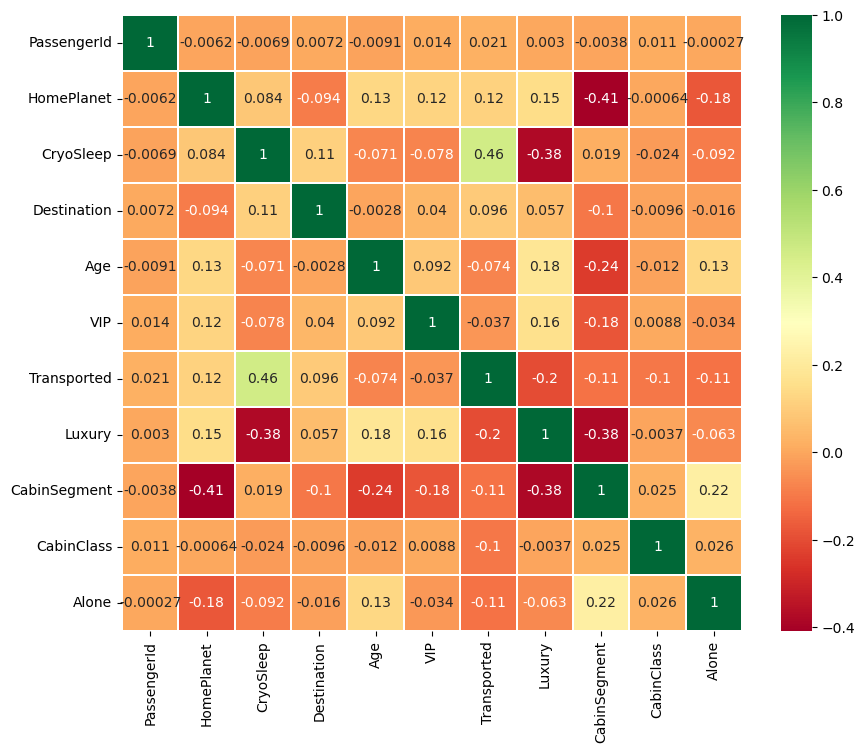

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Luxury,CabinSegment,CabinClass,Alone
4033,4306_01,3.0,0.0,2.0,22.0,0.0,1,1606.0,6.0,1.0,1
3798,4055_01,1.0,0.0,1.0,21.0,0.0,0,645.0,6.0,2.0,1
928,0992_04,2.0,0.0,2.0,35.0,1.0,0,9766.0,6.0,1.0,0
3117,3361_02,3.0,1.0,1.0,9.0,0.0,1,0.0,6.0,1.0,0
3082,3323_02,2.0,1.0,2.0,53.0,0.0,1,0.0,3.0,2.0,0


In [243]:
sns.heatmap(df1_heat.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()
df1_heat.sample(5)

I drew a column chart to see the passengers who were transported and those who were not.

Number of passengers didn't transported = 4315
Number of passengers transported = 4378


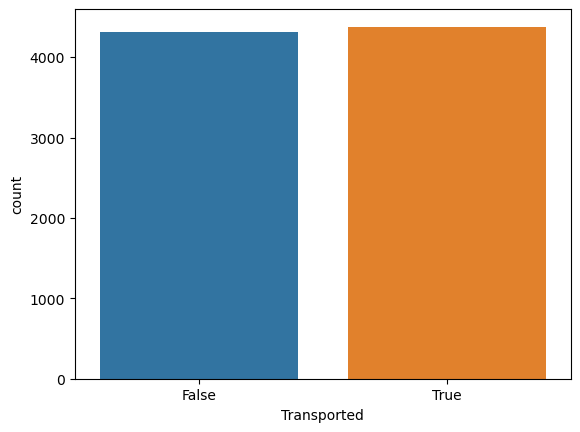

In [244]:
#Transported / Didn't Transported
transported = df_train.groupby('Transported').count()['PassengerId'].reset_index()
sns.countplot(x='Transported', data=df_train)
print("Number of passengers didn't transported = {}".format(transported['PassengerId'][0]))
print("Number of passengers transported = {}".format(transported['PassengerId'][1]))

I had column charts drawn for the 'VIP', 'CryoSleep', 'HomePlanet', 'Destination', 'Alone', 'CabinSegment', 'CabinClass' features, which I think play an important role in model selection.

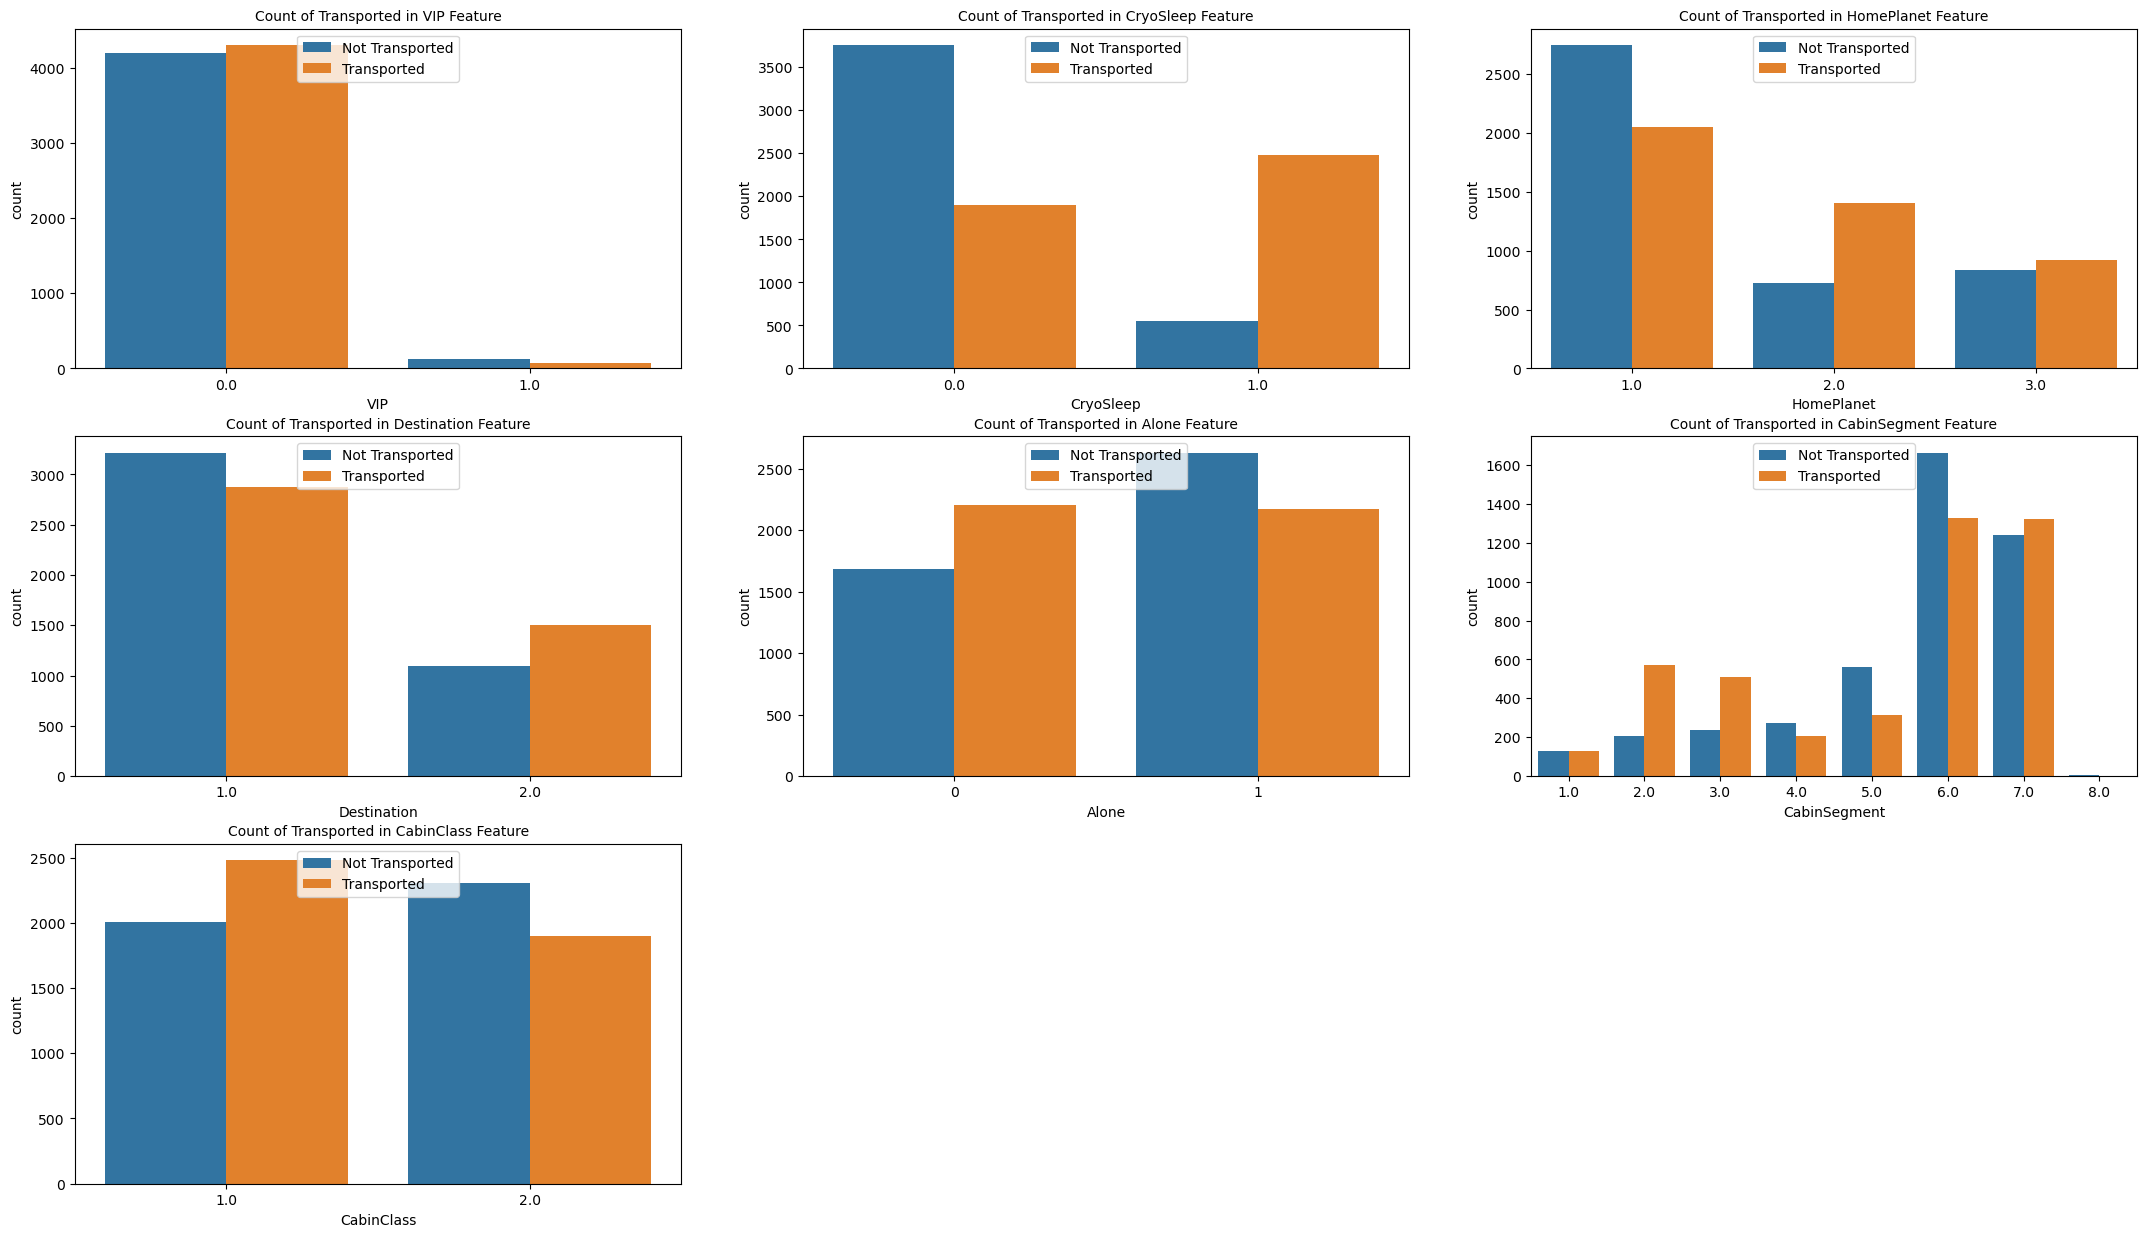

In [245]:
val = ['VIP', 'CryoSleep',"HomePlanet","Destination","Alone","CabinSegment","CabinClass"]
plt.figure(figsize=(15,15))
plt.subplots_adjust(right=1.5)
for i in range(7):
    plt.subplot(3,3,i+1), sns.countplot(x=val[i], hue='Transported', data = df1_heat)
    plt.legend(['Not Transported', 'Transported'], loc='upper center', prop={'size': 10})
    plt.title('Count of Transported in {} Feature'.format(val[i]), size=10, y=1)

I drew a histogram to see the age distribution of transported and non-transported passengers.

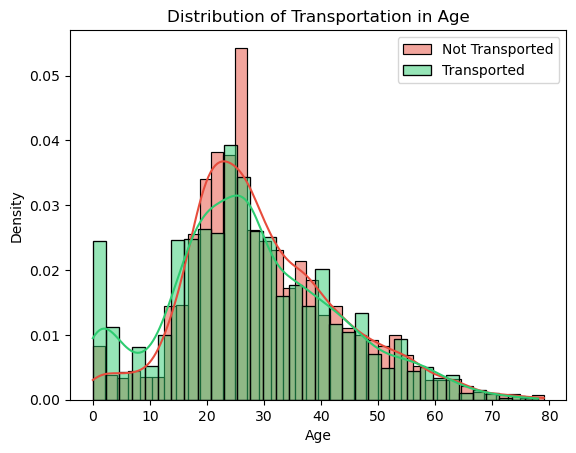

In [246]:
trsp = df1_heat['Transported'] == True
sns.histplot(df1_heat[~trsp]['Age'], label='Not Transported', kde=True, stat="density", color='#e74c3c')
sns.histplot(df1_heat[trsp]['Age'], label='Transported', kde=True, stat="density", color='#2ecc71')
plt.legend()
plt.title('Distribution of Transportation in Age')   
plt.show()

I drew a graph to see the distribution of transported and non-transported passengers according to luxury expenses.

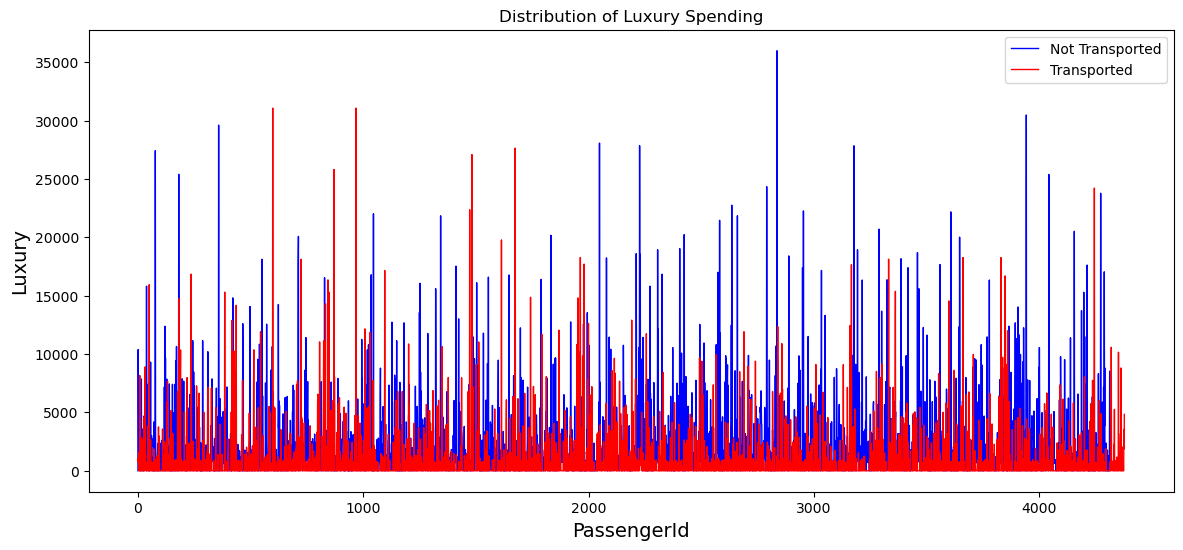

In [247]:
plt.figure(figsize=(14,6))
plt.plot(range(0,len(df1_heat[~trsp]['Luxury'])), df1_heat[~trsp]['Luxury'], color='blue', animated=True, linewidth=1)
plt.plot(range(0,len(df1_heat[trsp]['Luxury'])), df1_heat[trsp]['Luxury'], color='red', animated=True, linewidth=1)
plt.xlabel('PassengerId', fontsize=14)
plt.ylabel('Luxury', fontsize=14)
plt.legend(['Not Transported', 'Transported'])
plt.title('Distribution of Luxury Spending')
plt.show()

<a id='5'></a>
# **Feature Engineering**
We will apply feature engineering steps to both our training and test data. Here we are going to concat them so that we don't have to apply each steps separately. Then later on after applying feature engineering process we will separate them.

In [248]:
df2_heat=df_test[:]
df2_heat.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [249]:
#VIP or NOT to Boolean
X = df2_heat.iloc[:, 6].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["VIP"]=X

In [250]:
#CryoSleep or NOT
X = df2_heat.iloc[:, 2].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["CryoSleep"]=X

In [251]:
#Luxury - RoomService
X = df2_heat.iloc[:, 7].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["RoomService"]=X

In [252]:
#Luxury - FoodCourt
X = df2_heat.iloc[:, 8].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["FoodCourt"]=X

In [253]:
#Luxury - ShoppingMall
X = df2_heat.iloc[:, 9].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["ShoppingMall"]=X

In [254]:
#Luxury - Spa
X = df2_heat.iloc[:, 10].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["Spa"]=X

In [255]:
#Luxury - VRDeck
X = df2_heat.iloc[:, 11].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["VRDeck"]=X

In [256]:
#Luxury Total
df2_heat["Luxury"]=df2_heat["RoomService"]+df2_heat["FoodCourt"]+df2_heat["ShoppingMall"]+df2_heat["VRDeck"]+df2_heat["Spa"]

In [257]:
#CabinSegment A,B,C,D,E,F,G,T Nan Values Evaluate
df2_heat['CabinSegment']=df2_heat["Cabin"].astype(str)
df2_heat['CabinSegment']=df2_heat["CabinSegment"].str[0]
df2_heat['CabinSegment'] = [ ord(x)-64 for x in df2_heat['CabinSegment'] ]
df2_heat['CabinSegment'] = df2_heat['CabinSegment'].replace(46,np.nan)
df2_heat['CabinSegment'] = df2_heat['CabinSegment'].replace(20,8)
X = df2_heat.iloc[:, 14].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["CabinSegment"]=X

In [258]:
df2_heat['CabinClass'] = df2_heat["Cabin"].astype(str)
df2_heat['CabinClass'] = df2_heat["CabinClass"].str[-1]
df2_heat['CabinClass'] = [ ord(x)-64 for x in df2_heat['CabinClass'] ]
df2_heat['CabinClass'] = df2_heat['CabinClass'].replace(19,1)
df2_heat['CabinClass'] = df2_heat['CabinClass'].replace(16,2)
df2_heat['CabinClass'] = df2_heat['CabinClass'].replace(46,np.nan)
X = df2_heat.iloc[:, 15].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["CabinClass"]=X

In [259]:
#Destination  TRAPPIST-1e=1 PSO J318.5-22=2 55 Cancri e=3
df2_heat['Destination']=df2_heat["Destination"].astype(str)
df2_heat['Destination']=df2_heat["Destination"].str[0]
df2_heat["Destination"]= [ ord(x)-64 for x in df2_heat['Destination'] ]
df2_heat['Destination'] = df2_heat['Destination'].replace(20,1)
df2_heat['Destination'] = df2_heat['Destination'].replace(16,2)
df2_heat['Destination'] = df2_heat['Destination'].replace(-11,2)
df2_heat['Destination'] = df2_heat['Destination'].replace(46,np.nan)
X = df2_heat.iloc[:, 4].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["Destination"]=X

In [260]:
#HomePlanetClass Earth=1 Europa=2 Mars=3 
df2_heat['HomePlanet']=df2_heat["HomePlanet"].astype(str)
df2_heat['HomePlanet']=df2_heat["HomePlanet"].str[0:2]
df2_heat["HomePlanet"]= [ ord(x[0])-64+ord(x[1])-64 for x in df2_heat['HomePlanet'] ]
df2_heat['HomePlanet'] = df2_heat['HomePlanet'].replace(38,1)
df2_heat['HomePlanet'] = df2_heat['HomePlanet'].replace(58,2)
df2_heat['HomePlanet'] = df2_heat['HomePlanet'].replace(46,3)
df2_heat['HomePlanet'] = df2_heat['HomePlanet'].replace(79,np.nan)
X = df2_heat.iloc[:, 1].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["HomePlanet"]=X

In [261]:
#Age
X = df2_heat.iloc[:, 5].values
X= X.reshape(-1, 1)
# To calculate median (NanStrategy) use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy=NanStrategy)
imputer = imputer.fit(X)
X = imputer.transform(X)
df2_heat["Age"]=X

In [262]:
#from PessengerID Alone or Not
df2_heat['GroupID'] = df2_heat['PassengerId'].str[0:4]
df2_heat['InGroup']=df2_heat['GroupID'].apply(lambda x : (x, list(df2_heat['GroupID']).count(x))[1])
df2_heat['Alone']=df2_heat['InGroup'].apply(lambda x : 0 if x>1 else 1 )
df2_heat.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Luxury', 'CabinSegment', 'CabinClass', 'GroupID', 'InGroup',
       'Alone'],
      dtype='object')

In [263]:
df2_heat=df2_heat.drop(columns=["Cabin","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","Name","GroupID","InGroup"])

In [264]:
df2_heat.sample(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Luxury,CabinSegment,CabinClass,Alone
4254,9238_01,1.0,0.0,1.0,10.0,0.0,0.0,7.0,2.0,0
3111,6819_01,1.0,0.0,1.0,37.0,0.0,915.0,7.0,1.0,0
152,0335_01,3.0,0.0,1.0,22.0,0.0,0.0,5.0,1.0,1
372,0775_03,2.0,1.0,1.0,18.0,0.0,0.0,3.0,1.0,0
890,1845_01,2.0,0.0,1.0,33.0,0.0,7138.0,3.0,1.0,1


I concatenated Train and Test dataframes. (df1_heat: train, df2_heat: test)

In [265]:
df = pd.concat([df1_heat,df2_heat],ignore_index=True)

The types of data contained in the columns in the new dataframe are as follows:

In [266]:
df.dtypes

PassengerId      object
HomePlanet      float64
CryoSleep       float64
Destination     float64
Age             float64
VIP             float64
Transported     float64
Luxury          float64
CabinSegment    float64
CabinClass      float64
Alone             int64
dtype: object

A new dataframe was created by splitting the previous dataframe to make the train and test dataframes accessible by index numbers.

In [267]:
dfs = np.split(df, [len(df_train)], axis=0)

I checked the dimensions of the train dataframe to be used in the models. I used the tail command to understand that it was split in the right place. The last value of the Transported column should not be NaN.

In [268]:
train = dfs[0]
print(train.shape)
train.tail()

(8693, 11)


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Luxury,CabinSegment,CabinClass,Alone
8688,9276_01,2.0,0.0,2.0,41.0,1.0,0.0,8536.0,1.0,2.0,1
8689,9278_01,1.0,1.0,2.0,18.0,0.0,0.0,0.0,7.0,1.0,1
8690,9279_01,1.0,0.0,1.0,26.0,0.0,1.0,1873.0,7.0,1.0,1
8691,9280_01,2.0,0.0,2.0,32.0,0.0,0.0,4637.0,5.0,1.0,0
8692,9280_02,2.0,0.0,1.0,44.0,0.0,1.0,4826.0,5.0,1.0,0


I checked the dimensions of the test dataframe on which the selected model will be applied. I used the head method to understand that it was split at the right place. The first value of the Transported column should be NaN.

In [269]:
test = dfs[1]
print(test.shape)
test.head()

(4277, 11)


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Luxury,CabinSegment,CabinClass,Alone
8693,0013_01,1.0,1.0,1.0,27.0,0.0,NaN,0.0,7.0,1.0,1
8694,0018_01,1.0,0.0,1.0,19.0,0.0,NaN,2832.0,6.0,1.0,1
8695,0019_01,2.0,1.0,2.0,31.0,0.0,NaN,0.0,3.0,1.0,1
8696,0021_01,2.0,0.0,1.0,38.0,0.0,NaN,7418.0,3.0,1.0,1
8697,0023_01,1.0,0.0,1.0,20.0,0.0,NaN,645.0,6.0,1.0,1


I turned the train daframe into a spark dataframe so that SPARK ML can use it.

In [270]:
train = sqlContext.createDataFrame(train)

Since VectorAssembler is a transformer that combines a given list of columns into a single vector column, it is useful for combining raw features and features generated by different feature transformers into a single feature vector for training ML models such as Logistic regression and decision trees. I have defined VectorAssembler below. ('CryoSleep','VIP','Luxury','CabinSegment', 'CabinClass','Age','Alone','HomePlanet','Destination') Normalizer is used to normalize Vectors between Rows, not scalars between columns . I defined a normalizer because it is used in a similar way in models.

In [271]:
vector = VectorAssembler(inputCols=['CryoSleep','VIP','Luxury','CabinSegment', 'CabinClass','Age','Alone','HomePlanet','Destination'],outputCol='features')
normalizer = Normalizer(inputCol='features',outputCol='features_norm', p=1)

<h2>My first model is Logistic Regression</h2>

In [272]:
lor = LogisticRegression(featuresCol='features_norm', labelCol='Transported', maxIter=100)

The PySpark pipeline acts as a prediction tool; The pipeline consists of a transformer or sequence of stages as an estimator. I defined a pipeline for Logistic Regression. (pipeline1)

In [273]:
pipeline1 = Pipeline(stages=[vector,normalizer,lor])

In [274]:
model1 = pipeline1.fit(train)

First Prediction (Logistic Regression Prediction):

In [275]:
predictions1 = model1.transform(train)

I created an empty list for accuracy. I will keep the accuracy ratings of all models in this list.

In [276]:
accuracy = []

I use MulticlassClassificationEvaluator to measure the accuracy of Logistic Regression and other models.

In [277]:
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The Logistic Regression Model Accuracy is: " + str(eval.evaluate(predictions1)))
accuracy.append(eval.evaluate(predictions1))

The Logistic Regression Model Accuracy is: 0.7369147590014955


<h2>Next is Gradient-Boosted Trees (GBTs) learning algorithm for classification:</h2>

In [278]:
gbt = GBTClassifier(featuresCol='features_norm',labelCol='Transported',maxIter=100)
pipeline2 = Pipeline(stages=[vector,normalizer,gbt])
model2 = pipeline2.fit(train)
predictions2 = model2.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The Gradient-Boosted Trees Accuracy is: " + str(eval.evaluate(predictions2)))
accuracy.append(eval.evaluate(predictions2))

The Gradient-Boosted Trees Accuracy is: 0.7835039687104567


<h2>Now it's Linear Support Vector Classification's turn</h2>

In [279]:
svc = LinearSVC(featuresCol='features_norm', labelCol='Transported', maxIter=10)
pipeline3 = Pipeline(stages=[vector,normalizer,svc])
model3 = pipeline3.fit(train)
predictions3 = model3.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The Linear Support Vector Accuracy is: " + str(eval.evaluate(predictions3)))
accuracy.append(eval.evaluate(predictions3))

The Linear Support Vector Accuracy is: 0.7367997239157943


<h2>Decision Tree:</h2>

In [280]:
dt = DecisionTreeClassifier(featuresCol='features_norm', labelCol='Transported')
pipeline4 = Pipeline(stages=[vector,normalizer,dt])
model4 = pipeline4.fit(train)
predictions4 = model4.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The Decision Tree Accuracy is: " + str(eval.evaluate(predictions4)))
accuracy.append(eval.evaluate(predictions4))

The Decision Tree Accuracy is: 0.7427815483722535


<h2>Random Forest:</h2>

In [281]:
rfc = RandomForestClassifier(featuresCol='features_norm', labelCol='Transported')
pipeline5 = Pipeline(stages=[vector,normalizer,rfc])
model5 = pipeline5.fit(train)
predictions5 = model5.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The Random Forest Accuracy is: " + str(eval.evaluate(predictions5)))
accuracy.append(eval.evaluate(predictions5))

The Random Forest Accuracy is: 0.7377200046014034


<h2>Multilayer Perceptron Classifier:</h2>

In [282]:
layers = [9, 5, 4, 2]
trainer = MultilayerPerceptronClassifier(featuresCol='features_norm', labelCol='Transported', maxIter=100, layers=layers, blockSize=128, seed=1234)
pipeline6 = Pipeline(stages=[vector,normalizer,trainer])
model6 = pipeline6.fit(train)
predictions6 = model6.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The Multilayer Perceptron Classifier Accuracy is: " + str(eval.evaluate(predictions6)))
accuracy.append(eval.evaluate(predictions6))

The Multilayer Perceptron Classifier Accuracy is: 0.7393304958012193


The best accuracy seems to be GBT's. I supported this with graphics.

In [283]:
names = ['Logistic Regression', 'GBTClassifier', 'LinearSVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'MultilayerPerceptronClassifier']

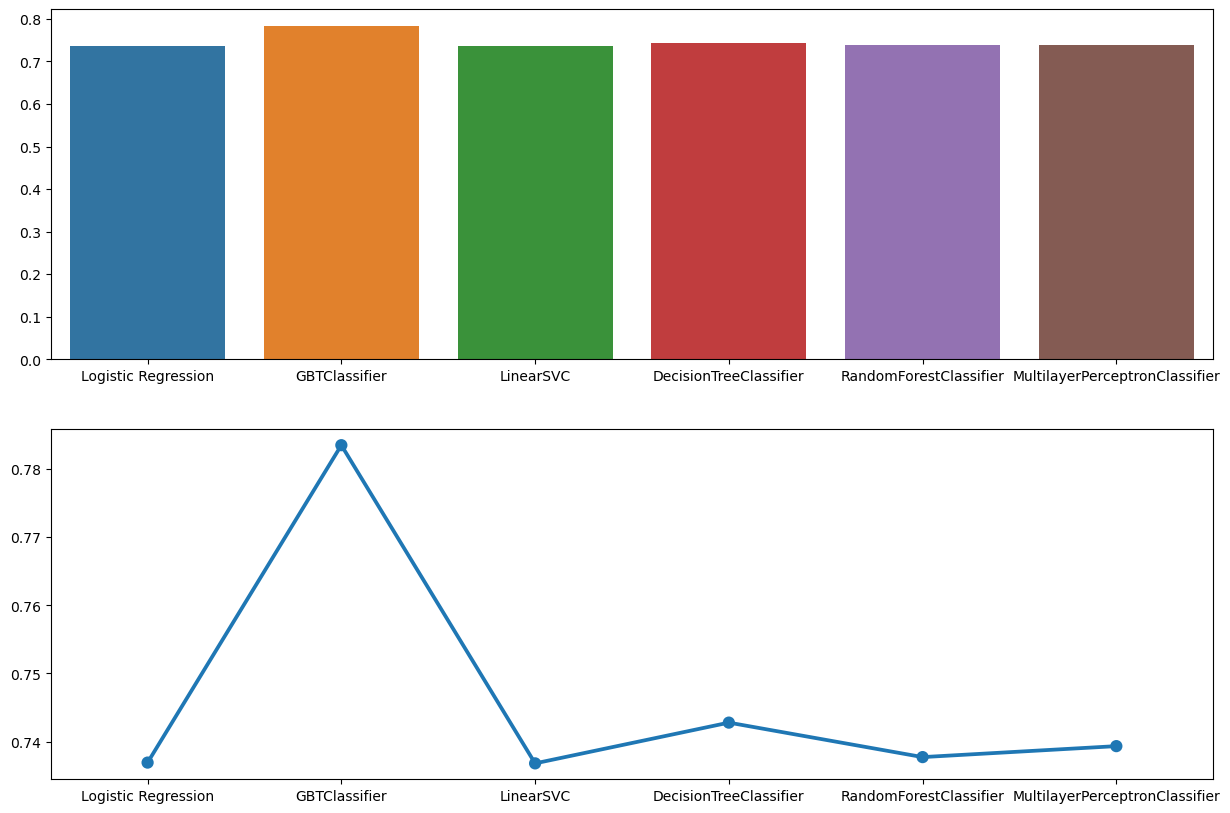

In [284]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
sns.barplot(x=names, y=accuracy, ax=ax[0])
sns.pointplot(x=names, y=accuracy, ax=ax[1])
plt.show()

Therefore, I had to apply the model I used for the second prediction to the test dataframe. 

In [285]:
predictions2.select("Transported", "prediction").show()

+-----------+----------+
|Transported|prediction|
+-----------+----------+
|        0.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        1.0|       1.0|
|        1.0|       0.0|
|        1.0|       1.0|
|        1.0|       1.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       1.0|
|        1.0|       1.0|
+-----------+----------+
only showing top 20 rows



In [286]:
test = sqlContext.createDataFrame(test)
predictions = model2.transform(test)
predictions = predictions.toPandas()

In [287]:
predictions.sample(20)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Luxury,CabinSegment,CabinClass,Alone,features,features_norm,rawPrediction,probability,prediction
243,0514_01,1.0,1.0,1.0,17.0,0.0,NaN,0.0,7.0,2.0,1,"[1.0, 0.0, 0.0, 7.0, 2.0, 17.0, 1.0, 1.0, 1.0]","[0.03333333333333333, 0.0, 0.0, 0.233333333333...","[-0.39161195777882335, 0.39161195777882335]","[0.3136254747344841, 0.6863745252655159]",1.0
958,2004_01,3.0,1.0,1.0,24.0,0.0,NaN,0.0,5.0,1.0,1,"[1.0, 0.0, 0.0, 5.0, 1.0, 24.0, 1.0, 3.0, 1.0]","[0.027777777777777776, 0.0, 0.0, 0.13888888888...","[-0.34243322918912833, 0.34243322918912833]","[0.3351760264269167, 0.6648239735730833]",1.0
863,1791_01,3.0,1.0,2.0,38.0,0.0,NaN,0.0,6.0,2.0,0,"[1.0, 0.0, 0.0, 6.0, 2.0, 38.0, 0.0, 3.0, 2.0]","[0.019230769230769232, 0.0, 0.0, 0.11538461538...","[-1.7771240114502982, 1.7771240114502982]","[0.027807501047168986, 0.972192498952831]",1.0
1140,2394_02,1.0,1.0,2.0,6.0,0.0,NaN,0.0,7.0,1.0,0,"[1.0, 0.0, 0.0, 7.0, 1.0, 6.0, 0.0, 1.0, 2.0]","[0.05555555555555555, 0.0, 0.0, 0.388888888888...","[-0.23387650132978607, 0.23387650132978607]","[0.3851482154431901, 0.6148517845568099]",1.0
760,1546_01,1.0,1.0,2.0,31.0,0.0,NaN,0.0,7.0,1.0,1,"[1.0, 0.0, 0.0, 7.0, 1.0, 31.0, 1.0, 1.0, 2.0]","[0.022727272727272728, 0.0, 0.0, 0.15909090909...","[-0.7391593547064215, 0.7391593547064215]","[0.18568150262396388, 0.8143184973760361]",1.0
1885,4041_01,1.0,1.0,1.0,29.0,0.0,NaN,0.0,7.0,1.0,1,"[1.0, 0.0, 0.0, 7.0, 1.0, 29.0, 1.0, 1.0, 1.0]","[0.024390243902439025, 0.0, 0.0, 0.17073170731...","[-0.4736524109916061, 0.4736524109916061]","[0.2794271669274264, 0.7205728330725736]",1.0
3635,7925_01,1.0,0.0,1.0,24.0,0.0,NaN,1031.0,6.0,1.0,1,"[0.0, 0.0, 1031.0, 6.0, 1.0, 24.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.968075117370892, 0.00563380281690...","[0.26930620405440114, -0.26930620405440114]","[0.63148956949957, 0.36851043050043]",0.0
434,0894_01,2.0,1.0,2.0,52.0,0.0,NaN,0.0,3.0,1.0,1,"[1.0, 0.0, 0.0, 3.0, 1.0, 52.0, 1.0, 2.0, 2.0]","[0.016129032258064516, 0.0, 0.0, 0.04838709677...","[-2.2109709652477654, 2.2109709652477654]","[0.011868336094734443, 0.9881316639052655]",1.0
4201,9105_01,1.0,1.0,1.0,29.0,0.0,NaN,0.0,7.0,2.0,1,"[1.0, 0.0, 0.0, 7.0, 2.0, 29.0, 1.0, 1.0, 1.0]","[0.023809523809523808, 0.0, 0.0, 0.16666666666...","[-0.11983768410293388, 0.11983768410293388]","[0.44036635268541985, 0.5596336473145802]",1.0
1091,2307_05,1.0,1.0,1.0,7.0,0.0,NaN,0.0,5.0,1.0,0,"[1.0, 0.0, 0.0, 5.0, 1.0, 7.0, 0.0, 1.0, 1.0]","[0.0625, 0.0, 0.0, 0.3125, 0.0625, 0.4375, 0.0...","[-0.540439164782219, 0.540439164782219]","[0.253339836935608, 0.746660163064392]",1.0


Thank you for your time.